<a href="https://colab.research.google.com/github/Zardian18/GANs-MNIST/blob/master/GANs_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

## Discriminator

In [2]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)


## Generator

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.gen(x)

## Hyperparameter

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1
batch_size = 32
num_epochs = 50

In [5]:
print(torch.cuda.is_available())

True


In [6]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [7]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0

100%|██████████| 9912422/9912422 [00:00<00:00, 172334554.38it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 36875401.47it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43641919.85it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2705656.69it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [8]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]


        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1

Epoch [0/50] Batch 0/1875                       Loss D: 0.6700, loss G: 0.6774
Epoch [1/50] Batch 0/1875                       Loss D: 0.5496, loss G: 1.0935
Epoch [2/50] Batch 0/1875                       Loss D: 0.4550, loss G: 1.1747
Epoch [3/50] Batch 0/1875                       Loss D: 0.5323, loss G: 1.1917
Epoch [4/50] Batch 0/1875                       Loss D: 0.5360, loss G: 1.1210
Epoch [5/50] Batch 0/1875                       Loss D: 1.0813, loss G: 0.5568
Epoch [6/50] Batch 0/1875                       Loss D: 0.6599, loss G: 1.0015
Epoch [7/50] Batch 0/1875                       Loss D: 0.5574, loss G: 1.3032
Epoch [8/50] Batch 0/1875                       Loss D: 0.6044, loss G: 1.4518
Epoch [9/50] Batch 0/1875                       Loss D: 0.3895, loss G: 1.3440
Epoch [10/50] Batch 0/1875                       Loss D: 0.6178, loss G: 1.1497
Epoch [11/50] Batch 0/1875                       Loss D: 0.6478, loss G: 1.0012
Epoch [12/50] Batch 0/1875                       L

## Generated Output

In [14]:
import matplotlib.pyplot as plt
# Tensor.cpu(img_grid_fake[0])
# plt.imshow(img_grid_fake[0])
img_grid_fake.shape

torch.Size([3, 122, 242])

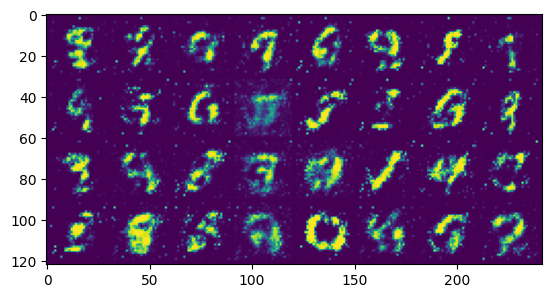

In [24]:
plt.imshow(img_grid_fake[0].cpu())